We used a SBM with two blocks or clusters C1 and C2. Each cluster consists of 10000 nodes. A randomly chosen pair of nodes is connected by an edge with probability 1/5 (1/100) if they belong to the same block (different blocks). The cluster (21) delivered by nLasso (6), with α = 1/10 and λ = 2/sqrt(sum(weights)) and using 10% randomly chosen seed nodes, perfectly recovered the true clusters.

In [1]:
import numpy as np
import random
import math

from stochastic_block_model import get_B_and_weight_vec
from sbm import SBM
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [66]:
ALPHA = 0.1

def run(N1, N2, K=15000, M=0.2, alpha = ALPHA):
    B, weight_vec = get_B_and_weight_vec([N1, N2], mu_in=2, mu_out=0.5, pin=0.2, pout=0.01)
    
    E, N = B.shape
    weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5
    
    samplingset = random.choices([i for i in range(N1)], k=int(M*N1))

    seednodesindicator= np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0
    
    lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    s = 0.0
    for item in range(len(weight_vec)):
        x = B[item].toarray()[0]
        i = np.where(x == -1)[0][0]
        j = np.where(x == 1)[0][0]
        if i < N1 <= j:
            s += weight_vec[item]
        elif i >= N1 > j:
            s += weight_vec[item]
    
    if lambda_nLasso * s >= alpha * N2 / 2:
        print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

        for dmy in range(len(samplingset)):
            idx_dmy = samplingset[dmy]
            newx[idx_dmy] = (newx[idx_dmy] + Gamma_vec[idx_dmy]) / (1 + Gamma_vec[idx_dmy])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)
    
    return history
    

In [3]:
def plot_sparse_charts(history):
    N = len(history[0])
    x_axis = [i for i in range(len(history))]
    plt.plot(x_axis, history[:, -1], label='0', color='green')
    plt.plot(x_axis, history[:, 0], label='1', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('x_hat')
    plt.show()

In [13]:
def plot_full_charts(history):
    N = len(history[0])
    x_axis = [i for i in range(len(history))]
    for i in range(N):
        if i < N/2:
            plt.plot(x_axis, history[:, i], label='1', color='red')
        else:
            plt.plot(x_axis, history[:, i], label='0', color='green')
    plt.xlabel('Iteration')
    plt.ylabel('x_hat')
    plt.show()

Lets start with 100 nodes in each cluster C1, C2 and a total number of 1000 iterations.
At the first plot you can see x_hat for each node in iterations and red lines belong to the nodes in the first cluster and the green lines are for others.

In [84]:
history = run(100, 100, K=1000)

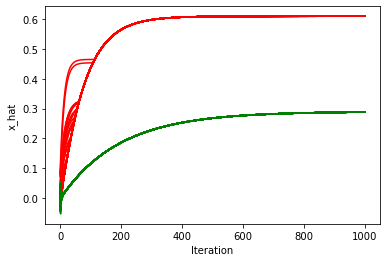

In [85]:
plot_full_charts(history)

As you see, after almost 1000 iterations the result will converge, while we can use kmeans to separate clusters after 20 iterations (only 2% of all needed iterations).

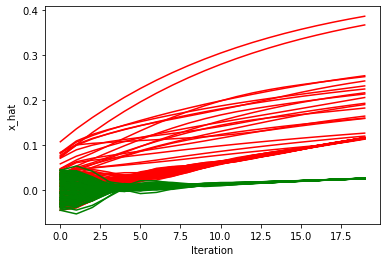

In [88]:
plot_full_charts(history[:20])

In [89]:
X = history[20]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Here we have 500 nodes in each cluster, and the total number of iterations is 5000.
At the first plot you can see x_hat for each node in iterations and red lines belong to the nodes in the first cluster and the green lines are for others.

In [90]:
history = run(500, 500, K=5000)

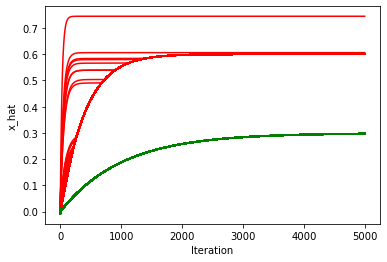

In [91]:
plot_full_charts(history)

As you see, after almost 5000 iterations the result will converge, while we can use kmeans to separate clusters after 100 iterations (only 2% of all needed iterations).

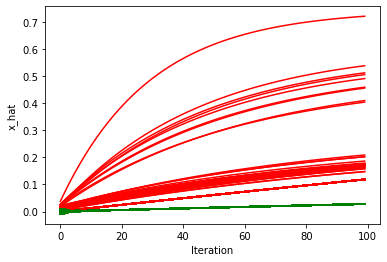

In [92]:
plot_full_charts(history[:100])

In [95]:
X = history[100]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
print(kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

At the end we have 500 nodes in each cluster, and the total number of iterations is 20000.
At the first plot you can see x_hat for each node in iterations and red lines belong to the nodes in the first cluster and the green lines are for others.

In [96]:
history = run(5000, 5000, K=20000)

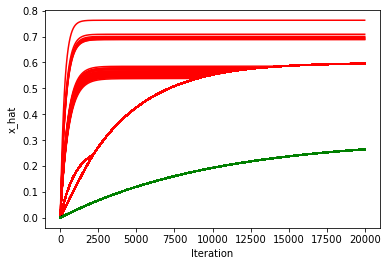

In [97]:
plot_full_charts(history)

As you see, after almost 20000 iterations the result hasn't converge and it need more iterations to converge, while we can use kmeans to separate clusters after 400 iterations (only 2% of all needed iterations).

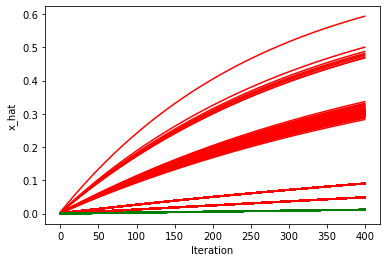

In [98]:
plot_full_charts(history[:400])

In [99]:
X = history[400]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
print(kmeans.labels_[:100], kmeans.labels_[-100:])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
